In [1]:
from astropy.io import fits
import h5py
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pymaster as nmt
import sacc

# Compare maps from TXPipe to Yuuki's Original ones & then Measure galaxy clustering in Fourier space with Namaster

## Load maps that TXPipe outputs

In [4]:
path_outputs = '/global/cscratch1/sd/jprat/TXPipe/data/gaussian_sims/outputs_gaussian_sims/gaussian_sims_srdnzs_fullsky/022422/12300area/2022/May4/'
# the mask is an input to TXPipe
mask_path = '/global/projecta/projectdirs/lsst/groups/WL/users/jprat/gaussian_sims_srdnzs_fullsky/022422/12300area/TXPipe_inputs/mask.hdf5'

density_maps = h5py.File(path_outputs + 'density_maps.hdf5', 'r')
mask_hdf5 = h5py.File(mask_path, 'r')


In [5]:
def plot_map(file_map, name):
    nside = 2048
    npix = hp.nside2npix(nside)
    map = np.zeros(npix)
    pix = file_map['maps/%s'%name]['pixel'][:]
    value = file_map['maps/%s'%name]['value'][:]
    print(value)
    map[pix]= value
    hp.mollview(map)
    
    return map


[1. 1. 1. ... 1. 1. 1.]


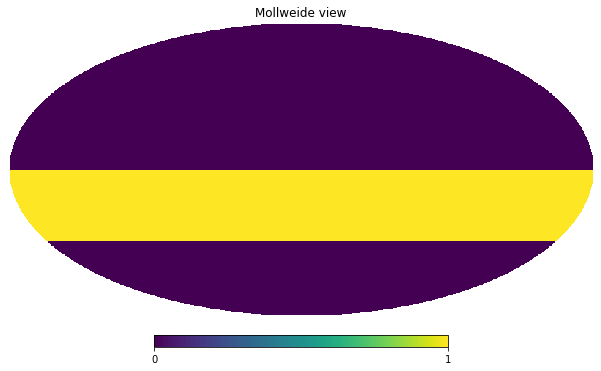

In [6]:
mask = plot_map(mask_hdf5, 'mask')

[-0.24729619  0.05378534  0.2043261  ... -0.24729619 -0.09675542
 -0.54837771]


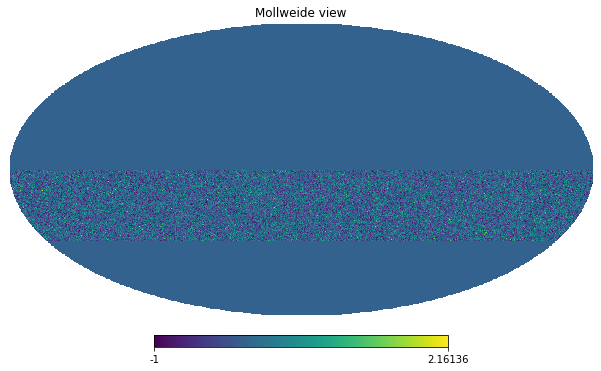

In [7]:
density_map_0 = plot_map(density_maps, 'delta_0')

### Compare with Yuuki's input map, before sampling

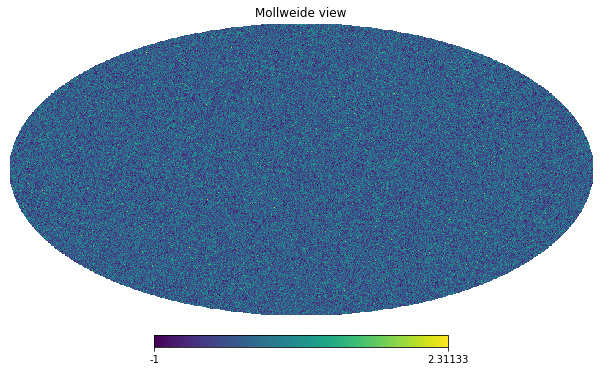

In [9]:
original_map_fullsky = hp.read_map('/global/projecta/projectdirs/lsst/groups/WL/users/jprat/gaussian_sims_srdnzs_fullsky/022422/lensdens_1_v022422.fits')
hp.mollview(original_map_fullsky)

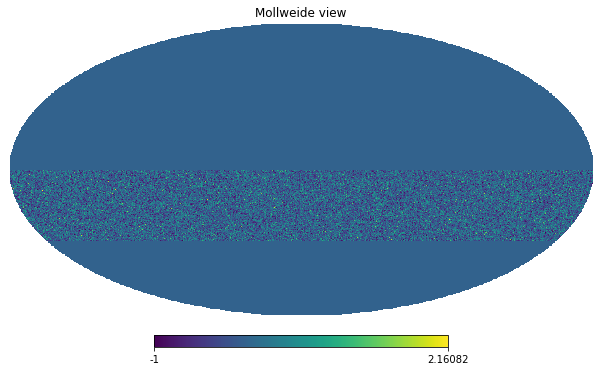

In [13]:
nside = 2048
npix = hp.nside2npix(nside)
map_orig = np.zeros(npix)
pix = mask_hdf5['maps/mask']['pixel'][:]

m = hp.pixelfunc.mask_good(mask, badval = 0)
map_orig[pix]= original_map_fullsky[m]
hp.mollview(map_orig)

[-0.24729619  0.05378534  0.2043261  ... -0.24729619 -0.09675542
 -0.54837771]


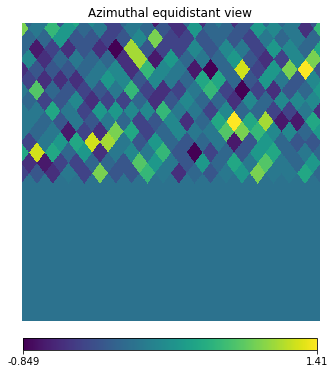

In [14]:
dec_lim = -36.606848299424534
%matplotlib inline
name = 'delta_0' 
nside = 2048
npix = hp.nside2npix(nside)
map = np.zeros(npix)
pix = density_maps['maps/%s'%name]['pixel'][:]
value = density_maps['maps/%s'%name]['value'][:]
print(value)
map[pix]= value
hp.azeqview(map, rot=(0, dec_lim), reso=0.05)

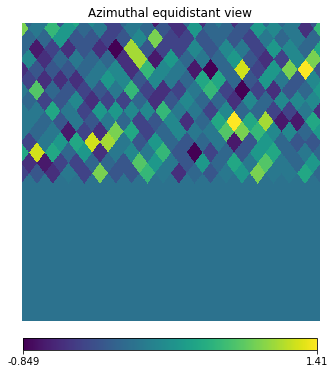

In [16]:
%matplotlib inline
hp.azeqview(map_orig, rot=(0, dec_lim), reso=0.05)

### Let's compare the distributions of the maps

Text(0.5, 0, 'Density contrast, bin 0')

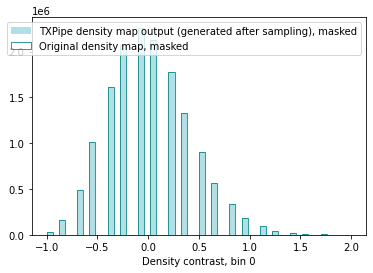

In [17]:
plt.hist(original_map_fullsky[m], bins = 50, range=(-1,2), color = 'powderblue', label =  'TXPipe density map output (generated after sampling), masked')
plt.hist(density_map_0[m], bins = 50, range=(-1,2), color = 'teal',  histtype = 'step', lw = 0.8, label =  'Original density map, masked')
plt.legend()
plt.xlabel('Density contrast, bin 0')
#plt.savefig('../plots/density_map_0.png', dpi = 300)

## Set ell binning and nside

In [16]:
def read_map(pixel, value):
    npix = hp.nside2npix(nside)
    map = np.zeros(npix)
    map[pix] = value
    return map

In [18]:
ell_min = 100
ell_max = 3*nside
n_ell = 30
ell_spacing = "log"

#taken from TXPipe to match exactly
ell_ini = [ 100,  115,  132,  153,  176,  203,  234,  270,  311,  358,  413,
        476,  549,  633,  730,  841,  969, 1117, 1288, 1485, 1711, 1972,
       2273, 2620, 3020, 3481, 4012, 4624, 5330]
ell_end = [115,  132,  153,  176,  203,  234,  270,  311,  358,  413,
        476,  549,  633,  730,  841,  969, 1117, 1288, 1485, 1711, 1972,
       2273, 2620, 3020, 3481, 4012, 4624, 5330, 6144]

ell_bins = nmt.NmtBin.from_edges(ell_ini, ell_end, is_Dell=False)
ls = ell_bins.get_effective_ells()

## Prepare density maps in Namaster format

### Masked map coming from TXPipe

In [17]:
nbin_lens = density_maps.file["maps"].attrs["nbin_lens"]
density_field = {}
for i in range(1):
    pixel = density_maps['maps/delta_%d/pixel'%i][:]
    value = density_maps['maps/delta_%d/value'%i][:]
    d_map0 = read_map(pixel, value)
    density_field['bin%d'%i] = (nmt.NmtField(mask, [d_map0], n_iter=0))


### Original map masked 

In [18]:
nbin_lens = density_maps.file["maps"].attrs["nbin_lens"]
density_field_orig = {}
for i in range(nbin_lens):
    density_field_orig['bin%d'%i] = (nmt.NmtField(mask, [map_orig], n_iter=0))


### Original map full sky

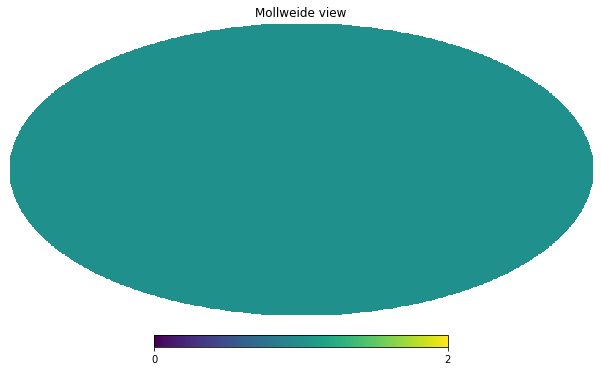

In [19]:
mask_fullsky = np.ones(len(mask))
hp.mollview(mask_fullsky)

nbin_lens = density_maps.file["maps"].attrs["nbin_lens"]
density_field_fullsky = {}
for i in range(nbin_lens):
    density_field_fullsky['bin%d'%i] = (nmt.NmtField(mask_fullsky, [original_map_fullsky], n_iter=0))


## Compute measurements using Namaster: these cell below takes a while ~1h 

### In the same order we prepared the maps

In [20]:
c = {}
for i in range(1):
    c['bin%d'%i] = nmt.compute_full_master(
                        density_field['bin%d'%i],
                        density_field['bin%d'%i],
                        ell_bins,
                        n_iter=1,
                    )

In [21]:
c_orig = {}
for i in range(1):
    c_orig['bin%d'%i] = nmt.compute_full_master(
                        density_field_orig['bin%d'%i],
                        density_field_orig['bin%d'%i],
                        ell_bins,
                        n_iter=1,
                    )

In [22]:
c_fullsky = {}
for i in range(1):
    c_fullsky['bin%d'%i] = nmt.compute_full_master(
                        density_field_fullsky['bin%d'%i],
                        density_field_fullsky['bin%d'%i],
                        ell_bins,
                        n_iter=1,
                    )

### Compare raw measurements

In [48]:
path_yuuki_m = '/global/projecta/projectdirs/lsst/groups/WL/users/yomori/repo/desc_analysis/gaussian_sims/gaussiancats/'
yuuki_m = np.loadtxt(path_yuuki_m + 'cls_l%d_s%d_l%d_s%d_seed999.dat'%(i, i, i, i))#signal
ell_y, TT_s, EE_s, BB_y, TE_y, TB_y, EB_y, ET_y, BT_y, BE_y = yuuki_m.T

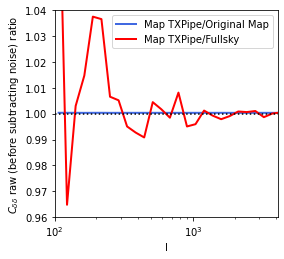

In [72]:
nlbins = 1
fig, ax = plt.subplots(1, nlbins, figsize=(4*nlbins, 4*0.95), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for i in range(nlbins):
    ell, cl_txpipe = a.get_ell_cl("galaxy_density_cl",'lens_%s'%(i) , 'lens_%s'%(i))
    ax.plot(ls, c['bin%d'%i][0]/c_orig['bin%d'%i][0], color = 'royalblue', lw = 2, label = 'Map TXPipe/Original Map')
    ax.plot(ls, c['bin%d'%i][0]/c_fullsky['bin%d'%i][0], color = 'red', lw = 2, label = 'Map TXPipe/Fullsky')
    
    ax.set_xlabel('l')
    ax.set_xscale('log')    
    ax.axhline(y=1, color = 'k', ls= ':')
    ax.set_xlim(100, 2*nside)
    ax.set_ylim(0.96, 1.04)

ax.set_ylabel(r'$C_{\delta\delta}$ raw (before subtracting noise) ratio')
ax.legend()

plt.savefig('../plots/compare_clustering_fourier_fullsky.png', dpi = 300,  bbox_inches = 'tight',  pad_inches = 0.1)

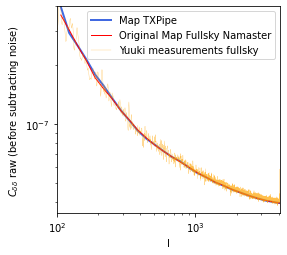

In [74]:
nlbins = 1
fig, ax = plt.subplots(1, nlbins, figsize=(4*nlbins, 4*0.95), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for i in range(nlbins):
    ell, cl_txpipe = a.get_ell_cl("galaxy_density_cl",'lens_%s'%(i) , 'lens_%s'%(i))
    ax.plot(ls, c['bin%d'%i][0], color = 'royalblue', lw = 2, label = 'Map TXPipe')
    #ax.plot(ls, c_orig['bin%d'%i][0], color = 'powderblue', lw = 2, label = 'Original Map')
    ax.plot(ls, c_fullsky['bin%d'%i][0], color = 'red', lw = 1, ls = '-', label = 'Original Map Fullsky Namaster')
    ax.plot(ell_y, TT_s, color = 'orange', lw = 0.3, label = 'Yuuki measurements fullsky', alpha= 0.7)
    
    ax.set_xlabel('l')
    ax.set_xscale('log')
    ax.set_yscale('log')
    #ax.axhline(y=1, color = 'k', ls= ':')
    ax.set_xlim(100, 2*nside)
    ax.set_ylim(3.5*10**(-8), 4*10**(-7))

ax.set_ylabel(r'$C_{\delta\delta}$ raw (before subtracting noise) ')
ax.legend()
plt.savefig('../plots/compare_clustering_fourier_fullsky_yuuki.png', dpi = 300,  bbox_inches = 'tight',  pad_inches = 0.1)

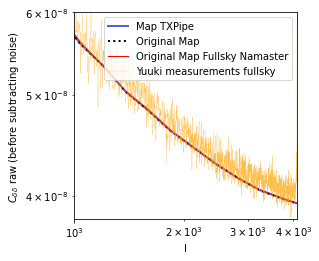

In [75]:
nlbins = 1
fig, ax = plt.subplots(1, nlbins, figsize=(4*nlbins, 4*0.95), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for i in range(nlbins):
    ell, cl_txpipe = a.get_ell_cl("galaxy_density_cl",'lens_%s'%(i) , 'lens_%s'%(i))
    ax.plot(ls, c['bin%d'%i][0], color = 'royalblue', lw = 2, label = 'Map TXPipe')
    ax.plot(ls, c_orig['bin%d'%i][0], color = 'black', lw = 2, ls = ':', label = 'Original Map')
    ax.plot(ls, c_fullsky['bin%d'%i][0], color = 'red', lw = 1, ls = '-', label = 'Original Map Fullsky Namaster')
    ax.plot(ell_y, TT_s, color = 'orange', lw = 0.3, label = 'Yuuki measurements fullsky', alpha= 0.7)
    
    ax.set_xlabel('l')
    ax.set_xscale('log')
    ax.set_yscale('log')
    #ax.axhline(y=1, color = 'k', ls= ':')
    ax.set_xlim(1000, 2*nside)
    ax.set_ylim(3.8*10**(-8), 6*10**(-8))

ax.set_ylabel(r'$C_{\delta\delta}$ raw (before subtracting noise) ')
ax.legend()
plt.savefig('../plots/compare_clustering_fourier_fullsky_yuuki_zoom.png', dpi = 300,  bbox_inches = 'tight',  pad_inches = 0.1)

## Subtract the noise from the measurements and correct for beam 

### First load TXPipe's measurement file with the noise we will subtract

In [40]:

dir = '/global/cscratch1/sd/jprat/TXPipe/data/gaussian_sims/outputs_gaussian_sims/gaussian_sims_srdnzs_fullsky/022422/12300area/2022/May4/' #scaled coupled noise
a = sacc.Sacc.load_fits(dir + 'twopoint_data_fourier.sacc')
a_name = 'analytic'

In [27]:
def window_pixel(ell, nside):
            r_theta = 1 / (np.sqrt(3.0) * nside)
            x = ell * r_theta
            f = 0.532 + 0.006 * (x - 0.5) ** 2
            y = f * x
            return np.exp(-(y**2) / 2)

def arcmin2_to_rad2(density):
    return density*60**2*41253/(4*np.pi)
lens_density = np.array([2.2512824191217113, 3.1115067729648382, 3.08574032321282, 2.6049633670894528, 2.002980579933056])
lens_density_rad = arcmin2_to_rad2(lens_density)
cl = {}
cl_orig = {}
cl_fullsky = {}
for i in range(1):
    n_ell_analytic = a.get_tag('n_ell', data_type="galaxy_density_cl", tracers=('lens_%s'%(i),'lens_%s'%(i)) )
    #cl['bin%d'%i] = (c['bin%d'%i][0]- 1/lens_density_rad[i])/ (window_pixel(ls, nside) ** 2)
    cl['bin%d'%i] = (c['bin%d'%i][0]- n_ell_analytic)/ (window_pixel(ls, nside) ** 2)
    cl_orig['bin%d'%i] = (c_orig['bin%d'%i][0]- n_ell_analytic)/ (window_pixel(ls, nside) ** 2)

## Compare with TXPipe measurements

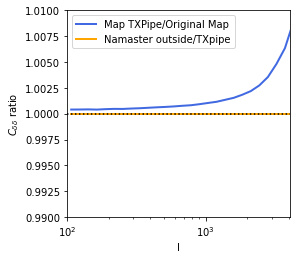

In [73]:
nlbins = 1
fig, ax = plt.subplots(1, nlbins, figsize=(4*nlbins, 4*0.95), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for i in range(nlbins):
    ell, cl_txpipe = a.get_ell_cl("galaxy_density_cl",'lens_%s'%(i) , 'lens_%s'%(i))
    ax.plot(ls, cl['bin%d'%i]/cl_orig['bin%d'%i], color = 'royalblue', lw = 2, label = 'Map TXPipe/Original Map')
    ax.plot(ls, cl['bin%d'%i]/cl_txpipe, color = 'orange', lw = 2, label = 'Namaster outside/TXpipe')
    #ax.plot(ls, cl['bin%d'%i]/cl_txpipe, color = 'red', lw = 2, label = 'Namaster outside/TXpipe')
    
    ax.set_xlabel('l')
    ax.set_xscale('log')    
    ax.axhline(y=1, color = 'k', ls= ':')
    ax.set_xlim(100, 2*nside)
    ax.set_ylim(0.99, 1.01)

ax.set_ylabel(r'$C_{\delta\delta}$ ratio')
ax.legend()
plt.savefig('../plots/compare_clustering_fourier.png', dpi = 300,  bbox_inches = 'tight',  pad_inches = 0.1)

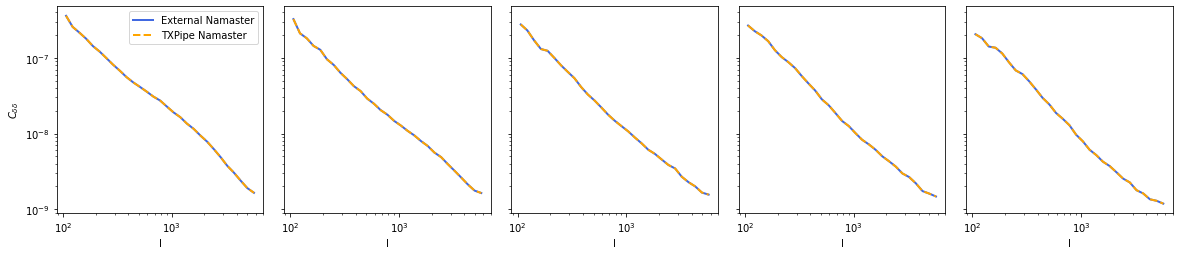

In [24]:
nlbins = 5
fig, ax = plt.subplots(1, nlbins, figsize=(4*nlbins, 4*0.95), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for i in range(nlbins):
    ell, cl_txpipe = a.get_ell_cl("galaxy_density_cl",'lens_%s'%(i) , 'lens_%s'%(i))
    ax[i].plot(ls, cl['bin%d'%i], color = 'royalblue', lw = 2, label = 'External Namaster')
    ax[i].plot(ls, cl_txpipe, color = 'orange', ls = '--', lw = 2, label = 'TXPipe Namaster')
    ax[i].set_xlabel('l')
    ax[i].set_xscale('log')
    ax[i].set_yscale('log') 
    #ax[i].axhline(y=1, color = 'k', ls= ':')
    #ax[i].set_xlim(100, 2*nside)
    #ax[i].set_ylim(0.999, 1.025)

ax[0].set_ylabel(r'$C_{\delta\delta}$')
ax[0].legend()

## Extra code that is not needed